In [91]:
# Ignore warnings
import warnings

warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer, Normalizer, scale
from sklearn.cross_validation import train_test_split, StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from sklearn import metrics
# Configure visualisations
% matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 8, 6


In [2]:
# Read data
train = pd.read_csv('/home/arturx/PycharmProjects/KaggleTest/train.csv')
test = pd.read_csv('/home/arturx/PycharmProjects/KaggleTest/test.csv')

full = train.append(test,ignore_index=True)
titanic = full[:891]
del test,train      

In [3]:
# Functions for data visualization

def plot_histograms(df, variables, n_rows, n_cols):
    fig = plt.figure(figsize=(16, 12))
    for i, var_name in enumerate(variables):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        df[var_name].hist(bins=10, ax=ax)
        ax.set_title(
            'Skew: ' + str(round(float(df[var_name].skew()), )))  # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels([], visible=False)
        ax.set_yticklabels([], visible=False)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution(df, var, target, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df, hue=target, aspect=4, row=row, col=col)
    facet.map(sns.kdeplot, var, shade=True)
    facet.set(xlim=(0, df[var].max()))
    facet.add_legend()

def plot_categories(df, cat, target, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df, row=row, col=col)
    facet.map(sns.barplot, cat, target)
    facet.add_legend()

def plot_correlation_map(df):
    corr = df.corr()
    _, ax = plt.subplots(figsize=(12, 10))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    _ = sns.heatmap(
        corr,
        cmap=cmap,
        square=True,
        cbar_kws={'shrink': .9},
        ax=ax,
        annot=True,
        annot_kws={'fontsize': 12}
    )

def describe_more(df):
    var = [];
    l = [];
    t = []
    for x in df:
        var.append(x)
        l.append(len(pd.value_counts(df[x])))
        t.append(df[x].dtypes)
    levels = pd.DataFrame({'Variable': var, 'Levels': l, 'Datatype': t})
    levels.sort_values(by='Levels', inplace=True)
    return levels

def plot_variable_importance(X, y):
    tree = DecisionTreeClassifier(random_state=99)
    tree.fit(X, y)
    plot_model_var_imp(tree, X, y)

def plot_model_var_imp(model, X, y):
    imp = pd.DataFrame(
        model.feature_importances_,
        columns=['Importance'],
        index=X.columns
    )
    imp = imp.sort_values(['Importance'], ascending=True)
    imp[: 10].plot(kind='barh')
    print (model.score(X, y))


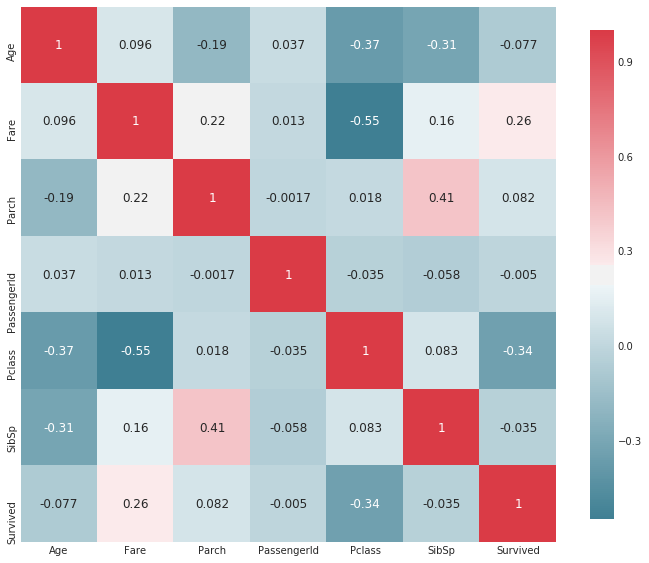

In [4]:
plot_correlation_map(titanic)

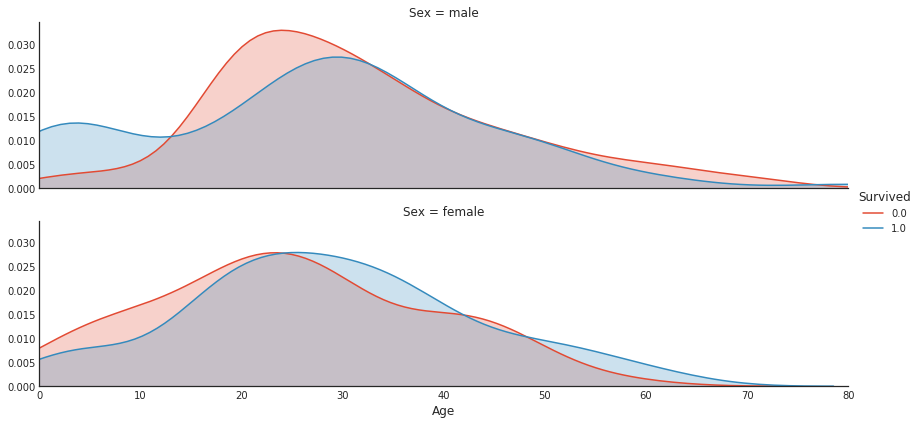

In [8]:
plot_distribution(titanic,var = 'Age',target= 'Survived',row='Sex')

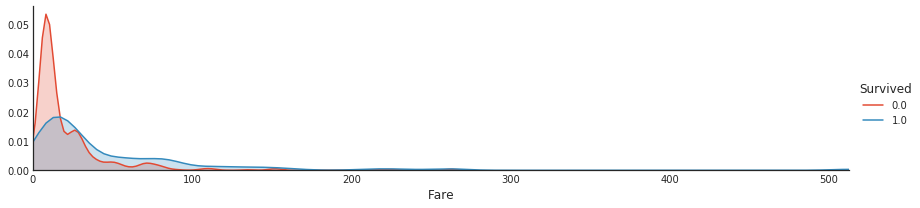

In [8]:
plot_distribution(titanic,var='Fare',target='Survived')

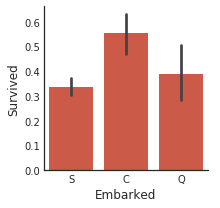

In [9]:
plot_categories(titanic,cat='Embarked',target='Survived')

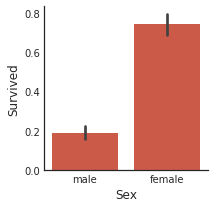

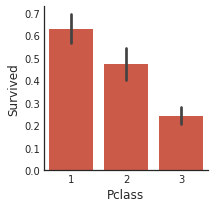

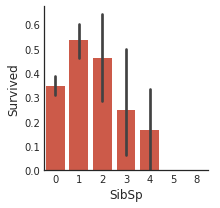

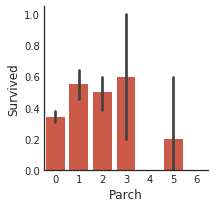

In [13]:
plot_categories(titanic, 'Sex', 'Survived')
plot_categories(titanic, 'Pclass', 'Survived')
plot_categories(titanic, 'SibSp', 'Survived')
plot_categories(titanic, 'Parch', 'Survived')


In [4]:
## IMP! Transform categorical variables

sex = pd.Series(np.where(full.Sex == 'male', 1, 0), name='Sex')
embarked = pd.get_dummies(full.Embarked, prefix='Embarked')
pclass = pd.get_dummies(full.Pclass, prefix='Pclass')

In [5]:
# Create a new DF, fill NotApplicable values with it's column's mean's
imputed = pd.DataFrame()
imputed['Age'] = full.Age.fillna(full.Age.mean())
imputed['Fare'] = full.Fare.fillna(full.Fare.mean())
imputed.head()

,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


In [6]:
imputed['Age'] = StandardScaler().fit_transform(imputed['Age'].reshape(-1,1))
imputed['Fare'] = StandardScaler().fit_transform(imputed['Fare'].reshape(-1,1))

In [7]:
# Create a new Features
title = pd.DataFrame()
title['Title'] = full['Name'].map(lambda name: name.split(',')[1].split('.')[0].strip())
title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"
                    }

title['Title'] = title.Title.map(title_Dictionary)
title = pd.get_dummies(title.Title)

In [8]:
cabin = pd.DataFrame()
# replacing missing cabins with u
cabin['Cabin'] = full.Cabin.fillna('U')
# mapping each cabin value with the cabin letter
cabin['Cabin'] = cabin['Cabin'].map(lambda c: c[0])
# dummy encoding
cabin = pd.get_dummies(cabin['Cabin'],prefix='Cabin')

In [9]:
# a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
def cleanTicket(ticket):
    ticket = ticket.replace('.', '')
    ticket = ticket.replace('/', '')
    ticket = ticket.split()
    ticket = map(lambda t: t.strip(), ticket)
    ticket = list(filter(lambda t: not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else:
        return 'XXX'

ticket = pd.DataFrame()

# Extracting dummy variables from tickets:
ticket['Ticket'] = full['Ticket'].map(cleanTicket)
ticket = pd.get_dummies(ticket['Ticket'], prefix='Ticket')


In [10]:
# create family size variables
family = pd.DataFrame()
family['FamilySize'] = full['Parch'] + full['SibSp'] + 1

family['Family_Single'] = family['FamilySize'].map(lambda s: 1 if s == 1 else 0)
family['Family_Small'] = family['FamilySize'].map(lambda s: 1 if 2 <= s <= 5 else 0)
family['Family_Big'] = family['FamilySize'].map(lambda s: 1 if s >= 5 else 0)


In [110]:
# now putting all variables together!
full_X = pd.concat([imputed, embarked, sex, family, ticket], axis=1)


In [116]:
# creating train and validation sets
train_valid_X = full_X[0:891]
train_valid_y = titanic.Survived
test_X = full_X[891:]
train_X, valid_X, train_y, valid_y = train_test_split(train_valid_X, train_valid_y, train_size=.85)
print train_X.shape

(757, 47)


In [117]:
models = [RandomForestClassifier(), GradientBoostingClassifier(),
          KNeighborsClassifier(), LogisticRegression(), DecisionTreeClassifier()]
prf = {'n_estimators': np.arange(10, 1000, 10),
       'max_features': np.arange(1, 47, 3),
       'max_depth': np.arange(1, 100, 10)}

pgb = prf

pknn = {
    'n_neighbors': np.arange(1, 10, 1),
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}
plr = {
    'penalty': ['l1', 'l2'],
    'C': np.arange(0.01, 0.1, 0.02)
}
tree_params = {
    'min_samples_leaf': np.arange(1, 40, 1),
    'max_features': np.arange(1, 30, 1),
    'max_depth': np.arange(1, 50, 1),
}
parameters = [prf, pgb, pknn, plr, tree_params]
from sklearn import neural_network, grid_search

fitted = []


In [118]:
# Trying get the best parametrs with grid search!
for name, model, param in zip(
        ['RandomForest', 'GradBoosting', 'KNeighbors', 'LogisticRegression', 'DecisionTree'],
        models, parameters):
    model = grid_search.GridSearchCV(model, param, scoring='f1', cv=6)
    model.fit(train_X, train_y)
    predict = model.predict(valid_X)
    print 'For model {} scoring\'s are:'.format(name)
    print '\t Absolute error is: {}'.format(metrics.mean_absolute_error(valid_y, predict))
    print '\t Squared error is: {}'.format(metrics.mean_squared_error(valid_y, predict))
    print '\t Precision score is: {}'.format(metrics.precision_score(valid_y, predict))
    print '\t Recall score is: {}'.format(metrics.recall_score(valid_y, predict))
    print '\t F1 score is: {}'.format(metrics.f1_score(valid_y, predict))
    print '\t Roc Auc score is: {}'.format(metrics.roc_auc_score(valid_y, predict))
    fitted.append(model)


For model RandomForest scoring's are:
	 Absolute error is: 0.186567164179
	 Squared error is: 0.186567164179
	 Precision score is: 0.69387755102
	 Recall score is: 0.772727272727
	 F1 score is: 0.731182795699
	 Roc Auc score is: 0.80303030303


For model GradBoosting scoring's are:
	 Absolute error is: 0.201492537313
	 Squared error is: 0.201492537313
	 Precision score is: 0.688888888889
	 Recall score is: 0.704545454545
	 F1 score is: 0.696629213483
	 Roc Auc score is: 0.774494949495


For model KNeighbors scoring's are:
	 Absolute error is: 0.216417910448
	 Squared error is: 0.216417910448
	 Precision score is: 0.682926829268
	 Recall score is: 0.636363636364
	 F1 score is: 0.658823529412
	 Roc Auc score is: 0.74595959596


For model LogisticRegression scoring's are:
	 Absolute error is: 0.194029850746
	 Squared error is: 0.194029850746
	 Precision score is: 0.725
	 Recall score is: 0.659090909091
	 F1 score is: 0.690476190476
	 Roc Auc score is: 0.768434343434


For model DecisionTree scoring's are:
	 Absolute error is: 0.179104477612
	 Squared error is: 0.179104477612
	 Precision score is: 0.75
	 Recall score is: 0.681818181818
	 F1 score is: 0.714285714286
	 Roc Auc score is: 0.785353535354


In [55]:
# Grid search by standard models with RFECV(???)
for name, model in zip(
        ['RandomForest', 'GradBoosting', 'KNeighbors', 'LogisticRegression'],
        models):
    print 'For model {} scoring\'s are:'.format(name)
    rfecv = RFECV(model, step=1, cv=StratifiedKFold(train_y, 2), scoring='f1')
    rfecv.fit(train_X, train_y)
    predict = rfecv.predict(valid_X)
    print ('\tScores :train {}, test {}'.format(rfecv.score(train_X, train_y), rfecv.score(valid_X, valid_y)))
    print("\tOptimal number of features : %d" % rfecv.n_features_)
    print '\t Absolute error is: {}'.format(metrics.mean_absolute_error(valid_y, predict))
    print '\t Squared error is: {}'.format(metrics.mean_squared_error(valid_y, predict))
    print '\t Precision score is: {}'.format(metrics.precision_score(valid_y, predict))
    print '\t Recall score is: {}'.format(metrics.recall_score(valid_y, predict))
    print '\t F1 score is: {}'.format(metrics.f1_score(valid_y, predict))
    print '\t Roc Auc score is: {}'.format(metrics.roc_auc_score(valid_y, predict))
    fitted.append(model)


For model RandomForest scoring's are:


	Scores :train 0.972712680578, test 0.817164179104
	Optimal number of features : 5
	 Absolute error is: 0.182835820896
	 Squared error is: 0.182835820896
	 Precision score is: 0.806451612903
	 Recall score is: 0.707547169811
	 F1 score is: 0.753768844221
	 Roc Auc score is: 0.79821802935
For model GradBoosting scoring's are:


	Scores :train 0.890850722311, test 0.828358208955
	Optimal number of features : 12
	 Absolute error is: 0.171641791045
	 Squared error is: 0.171641791045
	 Precision score is: 0.833333333333
	 Recall score is: 0.707547169811
	 F1 score is: 0.765306122449
	 Roc Auc score is: 0.807477288609
For model KNeighbors scoring's are:


RuntimeError: The classifier does not expose "coef_" or "feature_importances_" attributes

In [14]:
# Generate layers for network
tuples_2_l = []
tuples_3_l = []
tuples_4_l = []
for i in range(100):
    tuples_2_l.append((np.random.randint(1, 1000), np.random.randint(1, 1000)))
    tuples_3_l.append((np.random.randint(1, 500), np.random.randint(1, 500), np.random.randint(1, 500)))
    tuples_4_l.append(
        (np.random.randint(1, 100), np.random.randint(1, 100), np.random.randint(1, 100), np.random.randint(1, 100)))
neuro_params_2 = {
    'hidden_layer_sizes': tuples_2_l,
    'activation': ['relu', 'logistic', 'tanh']
}
neuro_params_3 = {
    'hidden_layer_sizes': tuples_3_l,
    'activation': ['relu', 'logistic', 'tanh']
}
neuro_params_4 = {
    'hidden_layer_sizes': tuples_4_l,
    'activation': ['relu', 'logistic', 'tanh']
}

In [29]:
# Train neural networks with grid parameters search
neuro_params = [neuro_params_2, neuro_params_3, neuro_params_4]
neros = []
for index, param in enumerate(neuro_params):
    model = grid_search.GridSearchCV(neural_network.MLPClassifier(), param, scoring='f1', cv=5)
    model.fit(train_X, train_y)
    predict = model.predict(valid_X)
    # if metrics.mean_absolute_error(valid_y, predict) < 0.17:
    print 'For neural nerwork number {} with cv ={} scorings are:'.format(index, i)
    print '\t Absolute error is: {}'.format(metrics.mean_absolute_error(valid_y, predict))
    print '\t Squared error is: {}'.format(metrics.mean_squared_error(valid_y, predict))
    print '\t Precision score is: {}'.format(metrics.precision_score(valid_y, predict))
    print '\t Recall score is: {}'.format(metrics.recall_score(valid_y, predict))
    print '\t F1 score is: {}'.format(metrics.f1_score(valid_y, predict))
    print '\t Roc Auc score is: {}'.format(metrics.roc_auc_score(valid_y, predict))
    print model.best_params_
    neros.append(model)
    

For neural nerwork number 0 with cv =99 scorings are:
	 Absolute error is: 0.201492537313
	 Squared error is: 0.201492537313
	 Precision score is: 0.795454545455
	 Recall score is: 0.660377358491
	 F1 score is: 0.721649484536
	 Roc Auc score is: 0.77463312369
{'activation': 'relu', 'hidden_layer_sizes': (34, 393)}


In [144]:
# Some XGBoost!
# p.s. Now with grid search!
from sklearn import model_selection
import xgboost

# Variables for boosting


xgb_pars = {
    'base_score':np.arange(0.1,1,0.1),
    'learning_rate': np.arange(0.01, 0.5, 0.01),
    'max_depth': np.arange(1, 100, 1),
    'n_estimators': np.arange(1, 100, 1)
}
def do_it(minimum):
    for i in range(2, 20, 1):
        booster = xgboost.XGBClassifier()
        searcher = grid_search.RandomizedSearchCV(estimator=booster,param_distributions=xgb_pars, scoring='f1', cv=i)
        searcher.fit(train_X, train_y)
        predict = searcher.predict(valid_X)
        if metrics.mean_absolute_error(valid_y, predict) < minimum:
            print 'For booster with cv={} scoring are:'.format(i)
            print '\t Accuracy is: {}'.format(metrics.accuracy_score(valid_y, predict))
            print '\t Absolute error is: {}'.format(metrics.mean_absolute_error(valid_y, predict))
            print '\t Squared error is: {}'.format(metrics.mean_squared_error(valid_y, predict))
            print '\t Precision score is: {}'.format(metrics.precision_score(valid_y, predict))
            print '\t Recall score is: {}'.format(metrics.recall_score(valid_y, predict))
            print '\t F1 score is: {}'.format(metrics.f1_score(valid_y, predict))
            print '\t Roc Auc score is: {}'.format(metrics.roc_auc_score(valid_y, predict))
            print searcher.best_params_
            boosted.append(searcher)
    if len(boosted) == 0:
        do_it(minimum)
        print 'Yohhiii!'

In [145]:
boosted = []
do_it(0.134)
# xgboost.XGBClassifier().get_params()

In [139]:
write_titan(boosted[1].predict(test_X))

In [53]:
def write_titan(ANSWERS):
    # test_Y = rfecv.predict( test_X )
    ANSWERS = map(lambda x: int(x), ANSWERS)
    passenger_id = full[891:].PassengerId
    test = pd.DataFrame({'PassengerId': passenger_id, 'Survived': ANSWERS})
    test.shape
    test.head()
    test.to_csv('/home/arturx/titanic_pred.csv', index=False)
